In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install yacs

In [0]:
import sys
import os
sys.path.append('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/')

In [0]:
import config
import time
import math
import levelnet
import torch
import glob
import cv2
import numpy as np
import torch.optim as optim
import torch.nn as nn
import scipy.io
from torchsummary import summary
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
cfg = config.get_cfg_defaults()
data = scipy.io.loadmat(cfg['dataset'].mat_path)

In [0]:
keypoint_names= [ 'Left Brow Left Corner',
                  'Left Brow Center',
                  'Left Brow Right Corner',
                  'Right Brow Left Corner',
                  'Right Brow Center',
                  'Right Brow Right Corner',
                  'Left Eye Left Corner',
                  'Left Eye Center',
                  'Left Eye Right Corner',
                  'Right Eye Left Corner',
                  'Right Eye Center',
                  'Right Eye Right Corner',
                  'Left Ear',
                  'Nose Left',
                  'Nose Center',
                  'Nose Right',
                  'Right Ear',
                  'Mouth Left Corner',
                  'Mouth Center',
                  'Mouth Right Corner',
                  'Chin Center' ]

In [0]:
def save_checkpoint(states= {}, is_best = True, output_dir = {} ,filename='checkpoint.pth.tar'):
    torch.save(states, os.path.join(output_dir, filename))
    if is_best and 'state_dict' in states:
        torch.save(states['state_dict'],os.path.join(output_dir, 'model_best.pth.tar'))

In [0]:
def get_preds(scores):
    maxval, idx = torch.max(scores.view(scores.size(0), scores.size(1), -1), 2)

    maxval = maxval.view(scores.size(0), scores.size(1), 1)
    idx = idx.view(scores.size(0), scores.size(1), 1) + 1

    preds = idx.repeat(1, 1, 2).float()

    preds[:, :, 0] = (preds[:, :, 0] - 1) % scores.size(3) + 1
    preds[:, :, 1] = torch.floor((preds[:, :, 1] - 1) / scores.size(3)) + 1

    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask
    return preds

In [0]:
def generate_target(img, pt, label_type='Gaussian'):
    sigma = 2
    tmp_size = 3
    ul = [int(pt[0] - tmp_size), int(pt[1] - tmp_size)]
    br = [int(pt[0] + tmp_size + 1), int(pt[1] + tmp_size + 1)]
    if (ul[0] >= img.shape[1] or ul[1] >= img.shape[0] or
            br[0] < 0 or br[1] < 0):
        return img

    size = sigma * tmp_size + 1
    #generate distribution range(0,1) and size
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    #normaliz
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g = torch.from_numpy(g)
    # check is gaussion of of bound only create in range
    g_x = max(0, -ul[0]), min(br[0], img.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], img.shape[0]) - ul[1]

    img_x = max(0, ul[0]), min(br[0], img.shape[1])
    img_y = max(0, ul[1]), min(br[1], img.shape[0])

    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

    
    return img

In [0]:
def get_index(name):
    cfg = config.get_cfg_defaults()
    global data
    for nm in range(len(data['imgs'])):
      #print(data['imgs'][nm])
      if data['imgs'][nm] == name:
          return int(nm)
    print(' data of file name : {}  not found '.format(name))

In [0]:
cfg = config.get_cfg_defaults()
model = levelnet.model()
optimizer = optim.Adam(model.parameters(), lr=cfg.TRAIN.lr, amsgrad = True)
criterion = nn.MSELoss(size_average=False)
print(cfg.TRAIN.lr)

0.0005


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
model.to(device)

model(
  (conv): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (batchNorm): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_64): layer_ds(
    (conv7): Conv2d(18, 36, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv5): Conv2d(18, 54, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv3): Conv2d(18, 108, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (relu): ReLU()
    (batchNorm): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (reduce): reduce(
      (reduce_plans): Conv2d(216, 108, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_32): layer_ds(
    (conv7): Conv2d(108, 72, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv5): Conv2d(108, 108, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv3): Conv2d(108, 216, kernel_size=(3, 3), stride=(2, 2), pad

In [0]:
summary(model, (3, 128, 128), 40)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [40, 18, 128, 128]             504
              ReLU-2         [40, 18, 128, 128]               0
       BatchNorm2d-3         [40, 18, 128, 128]              36
            Conv2d-4           [40, 36, 64, 64]          31,788
            Conv2d-5           [40, 54, 64, 64]          24,354
            Conv2d-6          [40, 108, 64, 64]          17,604
         AvgPool2d-7           [40, 18, 64, 64]               0
              ReLU-8          [40, 216, 64, 64]               0
       BatchNorm2d-9          [40, 216, 64, 64]             432
           Conv2d-10          [40, 108, 64, 64]          23,436
           Conv2d-11           [40, 72, 32, 32]         381,096
           Conv2d-12          [40, 108, 32, 32]         291,708
           Conv2d-13          [40, 216, 32, 32]         210,168
        AvgPool2d-14          [40, 108,

In [0]:
img_train = []
img_test = []
train_targets = []
test_targets = []
train_imgs_names = []
test_imgs_names = []
train_true_points = []
test_true_points = []
c = 0

In [0]:


for file_ in glob.glob(cfg['dataset'].train_path + '*.jpg'):
    target = np.zeros((cfg.out_features, cfg.img_h, cfg.img_w))
    file_name_ = file_.split('/')
    file_name = file_name_[-1]
    indx = get_index(file_name)
    pts = data['Pts'][indx]
    train_true_points.append(pts)
        # print(c, file_name)
        # print(pts)
    pts = pts.astype('float')

        # target data

    for i in range(len(pts[0])):
        target[i] = generate_target(target[i], [pts[0][i] - 1, pts[1][i] - 1])

    train_targets.append(torch.from_numpy(target).float())

        # imgae data tensor
    img = plt.imread(cfg['dataset'].train_path + file_name)
    
    
    
    
    transform = transforms.Compose(
        [
        transforms.ToPILImage(),
        transforms.Resize(cfg.img_h),
        transforms.CenterCrop(cfg.img_h),
        transforms.ToTensor(),
        transforms.Normalize(mean=cfg['dataset'].mean, std=cfg['dataset'].std)
        ])
      
      
      
    img_ = transform(img)
    img_train.append(img_)
    train_imgs_names.append(file_name)

    c += 1
    if c % 1000 == 0:
        print('image processed ',c)
print(" train dataset:  " + str(c))

image processed  1000
image processed  2000
image processed  3000
image processed  4000
image processed  5000
image processed  6000
 train dataset:  6892


In [0]:
c=0
for file in glob.glob(cfg['dataset'].test_path + '*.jpg'):

    target = np.zeros((cfg.out_features, cfg.img_h, cfg.img_w))
    file_name_ = file.split('/')
    file_name = file_name_[-1]

    pts = data['Pts'][get_index(file_name)]
    pts = pts.astype('float')
    test_true_points.append(pts)

    # target data
    for i in range(len(pts[0])):
        target[i] = generate_target(target[i], [pts[0][i] - 1, pts[1][i] - 1])
    test_targets.append(torch.from_numpy(target).float())

    
    # imgae data tensor
    img = plt.imread(cfg['dataset'].test_path + file_name)
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(cfg.img_h),
            transforms.CenterCrop(cfg.img_h),
            transforms.ToTensor(),
            transforms.Normalize(mean=cfg['dataset'].mean, std=cfg['dataset'].std)
        ]
    )
    
    
    img_ = transform(img)
    img_test.append(img_)

    test_imgs_names.append(file_name)
    c += 1
    if c % 1000 == 0:
      print('image processed ',c)

print(" test dataset:  " + str(c))

 test dataset:  277


In [0]:
#print(target)
data = scipy.io.loadmat(cfg['dataset'].mat_path)

In [0]:
indx = 1203

fl_name = train_imgs_names[indx]
pred_ = get_preds(torch.stack(train_targets[indx : indx + 1]))
print(pred_)
print(train_true_points[indx])
print(data['Pts'][get_index(fl_name)][0],data['Pts'][get_index(fl_name)][1])

tensor([[[ 62.,  59.],
         [ 65.,  55.],
         [ 71.,  55.],
         [ 81.,  54.],
         [ 87.,  52.],
         [ 92.,  54.],
         [ 64.,  62.],
         [ 67.,  61.],
         [ 74.,  60.],
         [ 85.,  58.],
         [ 90.,  57.],
         [ 93.,  57.],
         [  1.,  21.],
         [ 76.,  73.],
         [ 83.,  74.],
         [ 86.,  71.],
         [100.,  65.],
         [ 74.,  80.],
         [ 83.,  81.],
         [ 93.,  75.],
         [ 88.,  99.]]])
[[ 62.50666667  65.92        71.57333333  81.06666667  87.14666667
   92.48        64.85333333  67.73333333  74.24        85.65333333
   90.77333333  93.12         0.          76.8         83.09333333
   86.29333333 100.16        74.45333333  83.30666667  93.44
   88.53333333]
 [ 59.4         55.56        55.24        54.38666667  52.78666667
   54.17333333  62.70666667  61.85333333  60.68        58.22666667
   57.37333333  57.37333333  21.          73.26666667  74.12
   71.66666667  65.05333333  80.73333333  

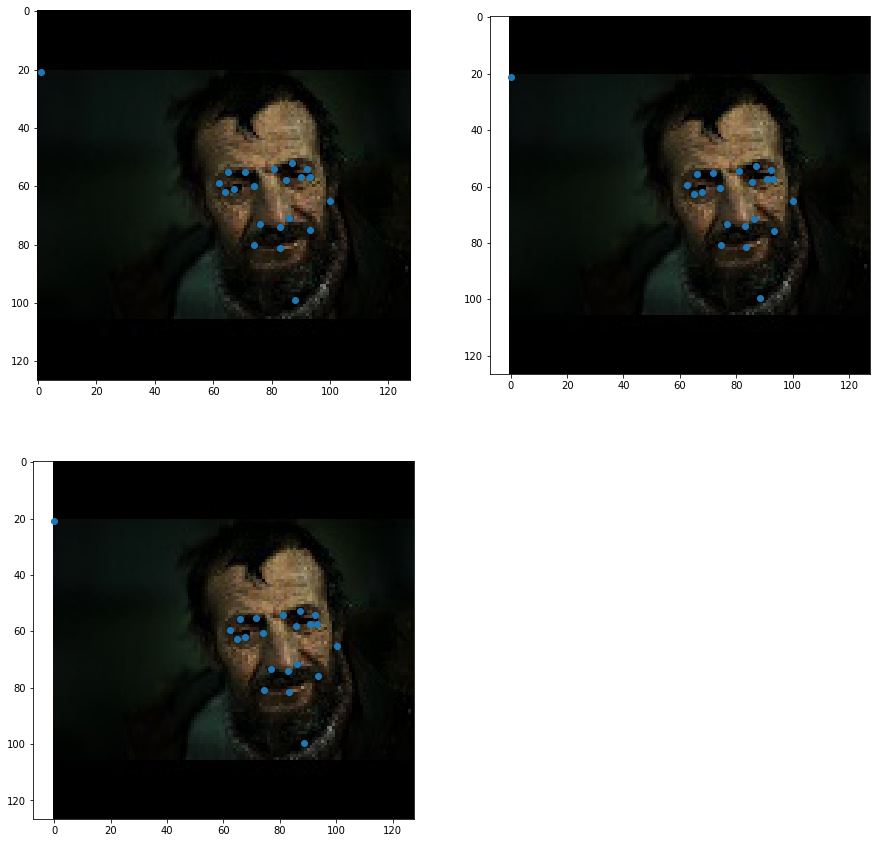

In [0]:
img_check = plt.imread("/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/AFLW/train_128_pxl/0_/" + fl_name)
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.imshow(img_check)
plt.scatter(pred_[:,:,0],pred_[:,:,1])
plt.subplot(2, 2, 2)
plt.imshow(img_check)
plt.scatter(data['Pts'][get_index(fl_name)][0],data['Pts'][get_index(fl_name)][1])
plt.subplot(2, 2, 3)
plt.imshow(img_check)
plt.scatter(train_true_points[indx][0],train_true_points[indx][1])
plt.savefig('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/sample.png')

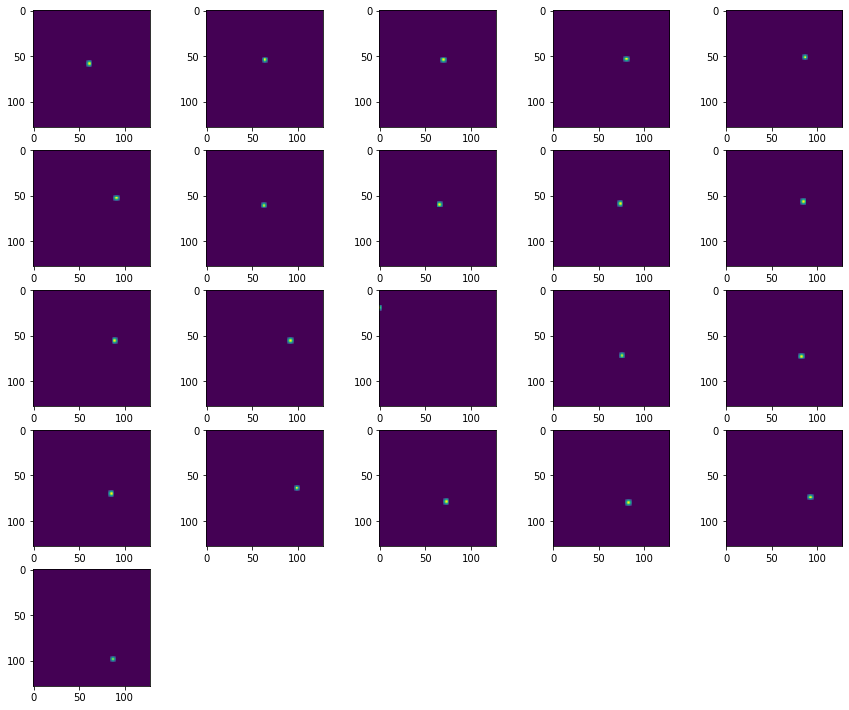

In [0]:
#img_check = plt.imread("/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/data_set/train/img/" + img_check)
plt.figure(figsize=(15,15))
columns = 5
rows = 6
for i in range(0, 21):
    if i == 21:
      plt.subplot(rows, columns, i+1)
      plt.imshow(img_check)
      plt.scatter(train_true_points[indx][0],train_true_points[indx][1], s=.1)
    else:
      arr = train_targets[indx][i]
      arr_ = np.squeeze(arr)
      plt.subplot(rows, columns, i+1)
      plt.imshow(arr_)
plt.savefig('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/out_targets.png')
plt.show()

In [0]:
def save_checkpoint(states= {}, is_best = True, output_dir = {} ,filename='checkpoint.pth.tar'):
    torch.save(states, os.path.join(output_dir, filename))
    if is_best and 'state_dict' in states:
        torch.save(states['state_dict'],os.path.join(output_dir, 'model_best.pth.tar'))

In [0]:
def comput_avg_pxl_dist(preds_score, true_points):
  avg_dist = 0

  preds = get_preds(preds_score)
  preds = preds.cpu().numpy()
  for i in range(len(true_points)):
    for j in range(len(preds[0])):
      
      #print(i,j,math.sqrt( (preds[i][j][0]-true_points[i][0][j])**2 + (preds[i][j][1]-true_points[i][1][j])**2 ))
      avg_dist += math.sqrt( (preds[i][j][0]-true_points[i][0][j])**2 + (preds[i][j][1]-true_points[i][1][j])**2 )
      #print(preds[i][j][0],true_points[i][0][j],preds[i][j][1],true_points[i][1][j])
      #print(i,j)
  
  len_data = len(true_points)
  #print(len_data)
  return avg_dist

#score_map =  train_targets[0:4]
#train_true_point_s = train_true_point[0:4]
#print(comput_avg_pxl_dist(score_map,train_true_point_s))

In [0]:
final_output_dir = '/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/model_state_dict'
model_state_file = os.path.join(final_output_dir,'checkpoint.pth.tar')
total_time = 0
if os.path.isfile(model_state_file):
  checkpoint = torch.load(model_state_file)
  last_epoch = checkpoint['epoch']
  total_time = checkpoint['total_time']
  best_val_loss = checkpoint['best_val_loss']
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print(" model succesfully loaded from last epoch:  {}".format(last_epoch))
else:
  last_epoch = 0
  total_time = 0
  best_val_loss = 2*31-1

 model succesfully loaded from last epoch:  265


In [0]:
epoch = 0 
def model_train():
    global cfg
    global best_val_loss
    global last_epoch
    global total_time
    data_length = len(img_train)
    print(' training.....')
    
    for epochs in range(last_epoch,last_epoch+1):
        epoch = epochs
        avg_loss = 0
        avg_val_loss = 0
        train_avg_dist = 0
        test_avg_dist = 0
        start = time.time()
        
        data_length = len(img_train)
        for i in range(data_length // cfg['TRAIN'].BATCH_SIZE):
            file_names = train_imgs_names[i * cfg['TRAIN'].BATCH_SIZE:(i + 1) * cfg['TRAIN'].BATCH_SIZE ]
            inputs = torch.stack(img_train[i * cfg['TRAIN'].BATCH_SIZE:(i + 1) * cfg['TRAIN'].BATCH_SIZE ]).to(device)
            targets = torch.stack(train_targets[i * cfg['TRAIN'].BATCH_SIZE:(i + 1) * cfg['TRAIN'].BATCH_SIZE ]).to(device)
            train_pts = train_true_points[i * cfg['TRAIN'].BATCH_SIZE:(i + 1) * cfg['TRAIN'].BATCH_SIZE]

            optimizer.zero_grad()
            #print(inputs.size())

            output = model.forward(inputs)

            loss = criterion(output, targets)
            loss.backward()
            avg_loss += loss.item()

            optimizer.step()
            
            #avg pixel dist bt truth and prediction
            train_avg_dist += comput_avg_pxl_dist(output, train_pts)

            #print( "  {0:} / {1:}     time: {2:.2f}   ".format(i*16,data_length,time.time()-start))
            

        file_names = train_imgs_names[cfg['TRAIN'].BATCH_SIZE * (data_length // cfg['TRAIN'].BATCH_SIZE): data_length]
        inputs = torch.stack(img_train[cfg['TRAIN'].BATCH_SIZE * (data_length // cfg['TRAIN'].BATCH_SIZE): data_length ]).to(device)
        targets = torch.stack(train_targets[cfg['TRAIN'].BATCH_SIZE * (data_length // cfg['TRAIN'].BATCH_SIZE): data_length]).to(device)

        optimizer.zero_grad()
        output = model.forward(inputs)
        #print(inputs.size())

        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        end = time.time()
        total_time += end-start
        train_pts = train_true_points[cfg['TRAIN'].BATCH_SIZE * (data_length // cfg['TRAIN'].BATCH_SIZE): data_length]

        #avg pixel dist bt truth and prediction
        train_avg_dist += comput_avg_pxl_dist(output, train_pts)


        #validation

        data_length = len(img_test)
        with torch.no_grad():
          BATCH_SIZE = cfg['TEST'].BATCH_SIZE
          for i in range(data_length // BATCH_SIZE):
            file_names = test_imgs_names[i * BATCH_SIZE:(i + 1) * BATCH_SIZE ]
            inputs = torch.stack(img_test[i * BATCH_SIZE:(i + 1) * BATCH_SIZE ]).to(device)
            targets = torch.stack(test_targets[i * BATCH_SIZE:(i + 1) * BATCH_SIZE ]).to(device)
            train_pts = test_true_points[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

            output = model.forward(inputs)

            loss = criterion(output, targets)
            avg_val_loss += loss.item()


            #avg pixel dist bt truth and prediction
            test_avg_dist += comput_avg_pxl_dist(output, train_pts)


          file_names = test_imgs_names[BATCH_SIZE * (data_length // BATCH_SIZE): data_length]
          inputs = torch.stack(img_test[BATCH_SIZE * (data_length // BATCH_SIZE): data_length ]).to(device)
          targets = torch.stack(test_targets[BATCH_SIZE * (data_length // BATCH_SIZE): data_length]).to(device)
          train_pts = test_true_points[BATCH_SIZE * (data_length // BATCH_SIZE): data_length]

  
        
          output = model.forward(inputs)
          test_avg_dist += comput_avg_pxl_dist(output, train_pts)

          loss = criterion(output, targets)
          avg_val_loss += loss.item()
     


          if best_val_loss < avg_val_loss:
            is_best = True
          else:
            is_best = False


          best_val_loss = min(best_val_loss, avg_val_loss)
        
  

        if not epochs==0:
          final_output_dir = '/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/model_state_dict'
          save_checkpoint(states = {
              'epoch': epochs + 1,
              'model': 'levelnet',
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'best_val_loss': best_val_loss,
              'total_time': total_time
              }, is_best = is_best, output_dir = final_output_dir, filename='checkpoint.pth.tar')
          

          final_model_state_file = os.path.join(final_output_dir,'final_state.pth.tar')
          torch.save(model.state_dict(), final_model_state_file)
        
        
        
    
        print('epochs:  {}   avg_loss:  {}     val_loss:  {}     train_avg_dst:  {}    test_avg_dst:  {}    time on epoch:  {} '.format(epochs, avg_loss/(len(img_train)), avg_val_loss/(len(img_test)), (train_avg_dist)/(29*len(img_train)), (test_avg_dist)/(29*len(img_test)),time.time() -start ))

        f = open('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/model_state_dict/model_losses_data.txt','a+')
        f.write('epochs:  {}   avg_loss:  {}     val_loss:  {}     train_avg_dst:  {}    test_avg_dst:  {}    time on epoch:  {}  \n'
        .format(epochs, avg_loss/(len(img_train)), avg_val_loss/(len(img_test)), (train_avg_dist)/(21*len(img_train)), (test_avg_dist)/(21*len(img_test)),time.time() -start ))
        f.close()

#model_train()

In [0]:
# save model after training


dont_save


final_output_dir = '/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/model_state_dict'
save_checkpoint(states = {
            'epoch': epoch + 1,
            'model': 'levelnet',
            'state_dict': model.state_dict(),
            'best_val_loss': best_val_loss,
            'optimizer': optimizer.state_dict(),
            'total_time': total_time
        }, is_best = False, output_dir = final_output_dir, filename='checkpoint.pth.tar')
final_model_state_file = os.path.join(final_output_dir,'final_state.pth.tar')
torch.save(model.state_dict(), final_model_state_file)

# Evaluate Model

In [0]:
def mode(x):
  if x>=0:
    return x
  else:
    return x*-1

In [0]:
def calculate_RMSE(preds,true_points):
  preds = get_preds(preds)
  preds = preds.cpu().numpy()
  error_x = np.zeros(21)
  error_y = np.zeros(21)
  for i in range(len(true_points)):
    for j in range(len(preds[0])):
      
      #print(i,j,math.sqrt( (preds[i][j][0]-true_points[i][0][j])**2 + (preds[i][j][1]-true_points[i][1][j])**2 ))
      error_x[j] += mode(preds[i][j][0]-true_points[i][0][j])/128
      error_y[j] += mode(preds[i][j][1]-true_points[i][1][j])/128
      #print(preds[i][j][0],true_points[i][0][j],preds[i][j][1],true_points[i][1][j])
      #print(i,j)
  return error_x,error_y


In [0]:
data_length = len(img_test)
keypoints_rmse = np.zeros(21)
errorX = 0
errorY = 0
with torch.no_grad():
    BATCH_SIZE = cfg['TEST'].BATCH_SIZE
    for i in range(data_length // BATCH_SIZE):
        inputs = torch.stack(img_test[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]).to(device)
        train_pts = test_true_points[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

        output = model.forward(inputs)

        error_x,error_y = calculate_RMSE(output, train_pts)
        errorX += error_x
        errorY += error_y

    inputs = torch.stack(img_test[BATCH_SIZE * (data_length // BATCH_SIZE): data_length]).to(device)
    train_pts = test_true_points[BATCH_SIZE * (data_length // BATCH_SIZE): data_length]


    output = model.forward(inputs)

    error_x,error_y = calculate_RMSE(output, train_pts)
    errorX += error_x
    errorY += error_y

error_X = (errorX*100)/(data_length)
error_Y = (errorY*100)/(data_length)

In [0]:
print('====================================================================')
print('{:<30}  {:>10}  {:>20}'.format('Keypoint Name','MAPE in X','MAPE in Y'))
for i in range(21):
  print('{:<30}  {:>6.2f}  {:>20.2f}'.format(keypoint_names[i],error_X[i],error_Y[i]))
print('====================================================================')
print('{:<30}  {:>6.3f}  {:>20.2f}'.format('Average error',sum(error_X)/21,sum(error_Y)/21))

Keypoint Name                    MAPE in X             MAPE in Y
Left Brow Left Corner             8.29                  7.09
Left Brow Center                  4.59                  3.23
Left Brow Right Corner            4.12                  4.07
Right Brow Left Corner            4.37                  3.23
Right Brow Center                 4.68                  2.99
Right Brow Right Corner          13.53                  7.26
Left Eye Left Corner              4.24                  3.35
Left Eye Center                   3.33                  2.50
Left Eye Right Corner             3.63                  2.82
Right Eye Left Corner             3.05                  2.98
Right Eye Center                  3.84                  3.01
Right Eye Right Corner            5.22                  3.75
Left Ear                          8.97                 10.81
Nose Left                         6.52                  6.67
Nose Center                       2.31                  2.08
Nose Right          



# *Load best model* 



In [0]:
def predict(img):

  w, h = img.shape[:2]
  ratio = float(128 / max(w, h))
        

  w_c = w * ratio

  h_c = h * ratio
  d_w = 128 - w_c
  d_h = 128 - h_c
  top_ = d_w // 2
  bottom_ = d_w // 2 
  left_ = d_h // 2
  right_ =d_h // 2
  img = cv2.resize(img, (int(h_c), int(w_c)))
    
  color = [0,0,0]
  img = cv2.copyMakeBorder(img, int(top_), int(bottom_), int(left_), int(right_), cv2.BORDER_CONSTANT,value=color)
  
  
  transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(128),
                transforms.CenterCrop(128),
                transforms.ToTensor(),
                transforms.Normalize(mean=cfg['dataset'].mean, std=cfg['dataset'].std)
            ])
  img_ = transform(img)
  img_tensor = []
  img_tensor.append(img_)
  img_tensors = torch.stack(img_tensor).to(device)
  with torch.no_grad():
    output = model.forward(img_tensors)
    pred   = get_preds(output)

  return [pred,img]

In [0]:
drive.mount('/content/drive')
model_dict= torch.load('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/model_state_dict/model_best.pth.tar')
model.load_state_dict(model_dict)
model.to(device)
model.eval()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


model(
  (conv): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (batchNorm): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_64): layer_ds(
    (conv7): Conv2d(18, 36, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv5): Conv2d(18, 54, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv3): Conv2d(18, 108, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (relu): ReLU()
    (batchNorm): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (reduce): reduce(
      (reduce_plans): Conv2d(216, 108, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_32): layer_ds(
    (conv7): Conv2d(108, 72, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv5): Conv2d(108, 108, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv3): Conv2d(108, 216, kernel_size=(3, 3), stride=(2, 2), pad

In [0]:
def plot_pred(img_path,name):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pred_out,img = predict(img)
  X = pred_out[:,:,0].cpu()[0]
  Y = pred_out[:,:,1].cpu()[0]
  plt.figure(figsize=(10,10))
  plt.scatter(X, Y)
  for i in range(len(keypoint_names)):
    plt.text(X[i]+.2, Y[i]+.2, i, fontsize=9)
  plt.imshow(img) 
  plt.savefig('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/'+name) 
  plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


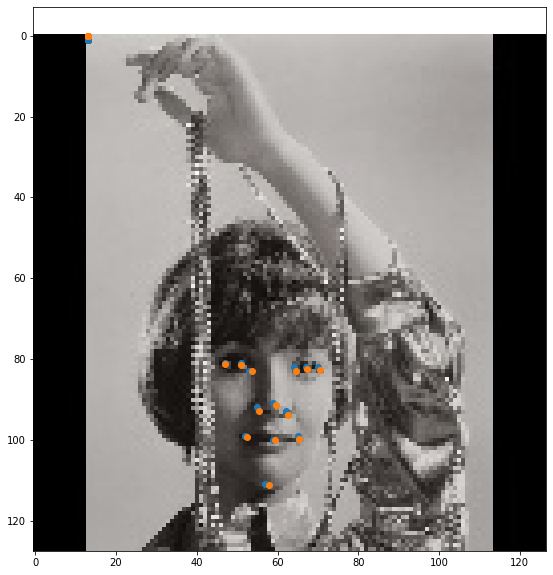

In [0]:
drive.mount('/content/drive')
img_path = '/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/AFLW/train_128_pxl/0_/' + train_imgs_names[10]

img = cv2.imread(img_path)
pred_out,img = predict(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.scatter(pred_out[:,:,0].cpu(),pred_out[:,:,1].cpu())
plt.imshow(img)
train_pts = train_true_points[10]
plt.scatter(train_pts[0],train_pts[1])

In [0]:
for i in range(len(keypoint_names)):
  print("{}    {}".format(i,keypoint_names[i]))

0    Left Brow Left Corner
1    Left Brow Center
2    Left Brow Right Corner
3    Right Brow Left Corner
4    Right Brow Center
5    Right Brow Right Corner
6    Left Eye Left Corner
7    Left Eye Center
8    Left Eye Right Corner
9    Right Eye Left Corner
10    Right Eye Center
11    Right Eye Right Corner
12    Left Ear
13    Nose Left
14    Nose Center
15    Nose Right
16    Right Ear
17    Mouth Left Corner
18    Mouth Center
19    Mouth Right Corner
20    Chin Center


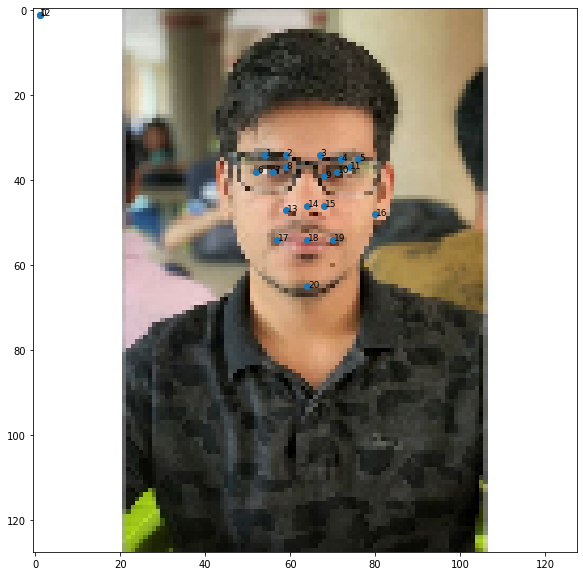

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/agni1.jpg','agni_pred.jpg')

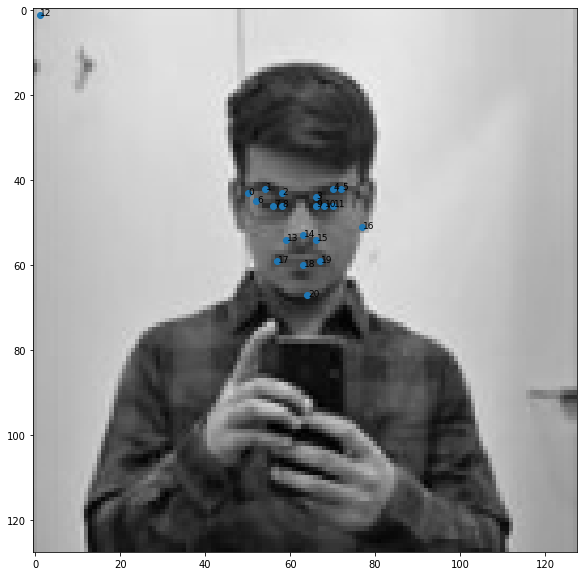

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/agni.jpg','agni_2_pred.jpg')

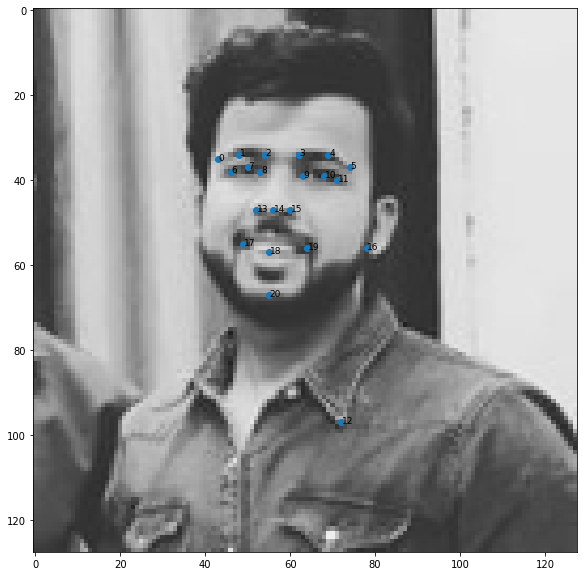

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/51516431_397708254140539_6425034254614265856_n.jpg','sarthal.jpg')

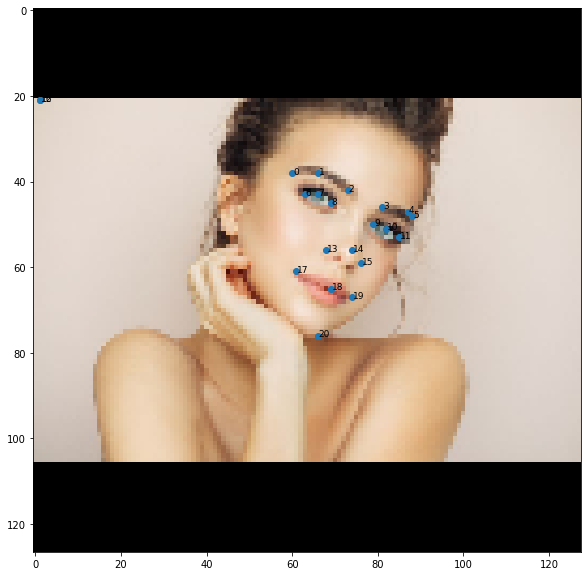

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/test_imgs_/beautiful-woman-with-natural-make-up-897056188-5c2d3aff4cedfd000165bdef.jpg','5c2d3aff4cedfd000165bdef.jpg')

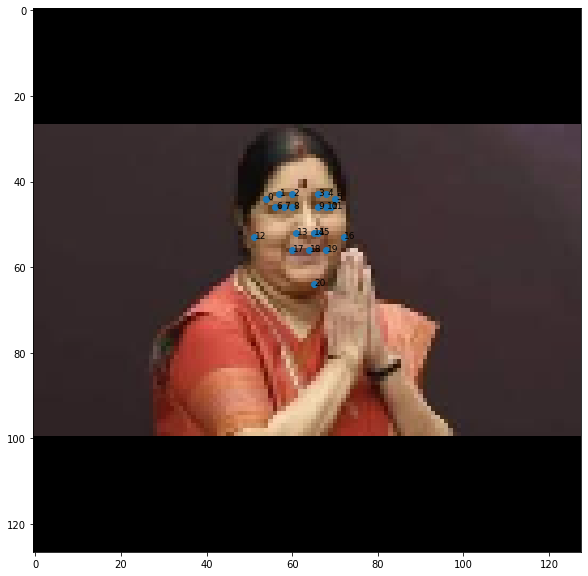

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/test_imgs_/images (1).jpg','images (1).jpg')

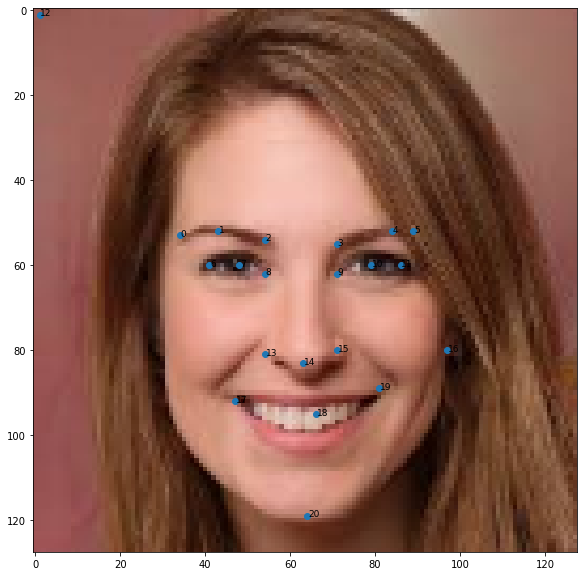

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/test_imgs_/images (2).jpg','images (2).jpg')

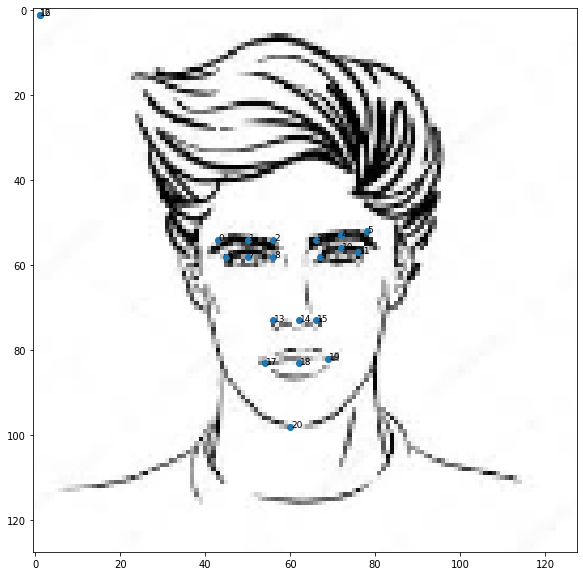

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/test_imgs_/images2.jpeg','images2.jpeg')

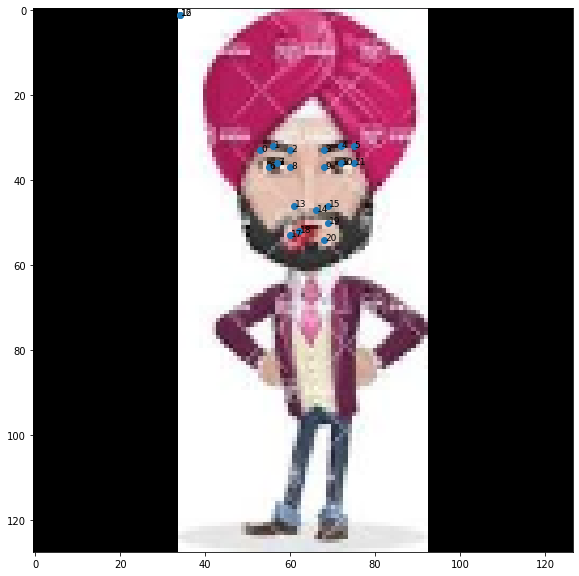

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/test_imgs_/images3.jpeg','images3.jpeg')

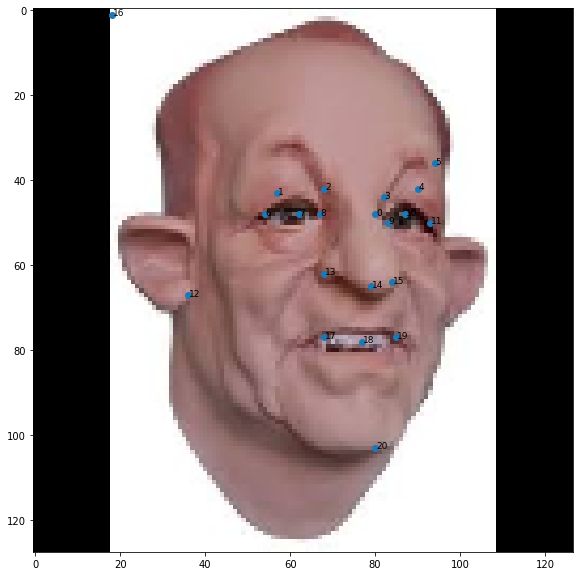

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/test_imgs_/images.jpg','images3.jpg')

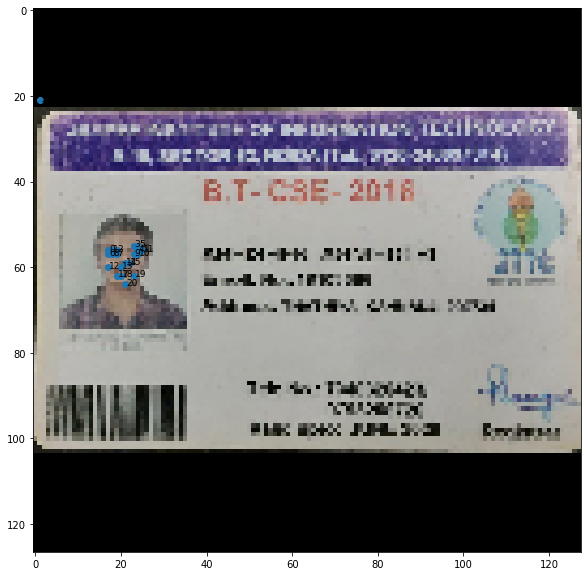

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/test_imgs_/WhatsApp Image 2019-10-15 at 2.30.04 AM.jpeg','WhatsApp Image 2019-10-15 at 2.30.04 AM.jpeg')

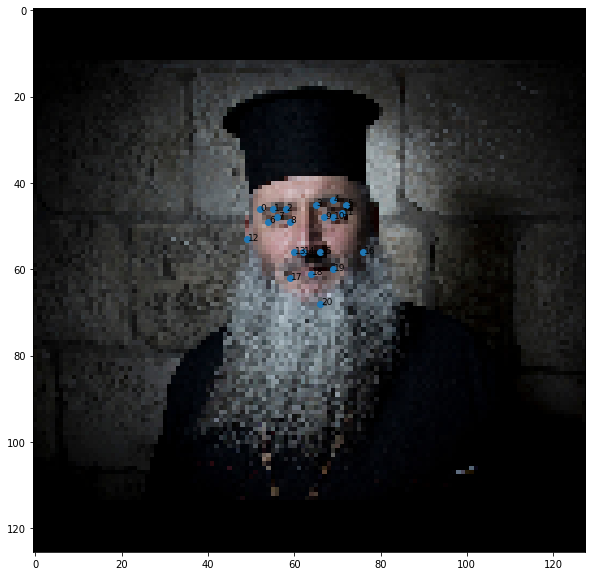

In [0]:
plot_pred('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/test_imgs_/180216-jerusalem-beards-belief-03.jpg','180216-jerusalem-beards-belief-03.jpg')

# Model Graph

In [0]:
%matplotlib inline
from graphviz import Digraph
import re
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Variable
import torchvision.models as models

from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

from torchvision import models
inputs = torch.randn(1,3,128,128).to(device)
y = model(Variable(inputs))
# print(y)

g = make_dot(y, model.state_dict())
g.view()

{140558005987080: 'conv.weight', 140558005986792: 'conv.bias', 140558005987296: 'batchNorm.weight', 140558005987152: 'batchNorm.bias', 140558005986648: 'batchNorm.running_mean', 140558005987008: 'batchNorm.running_var', 140558005987656: 'batchNorm.num_batches_tracked', 140558005987872: 'layer_64.conv7.weight', 140558005988016: 'layer_64.conv7.bias', 140558005988232: 'layer_64.conv5.weight', 140558005988376: 'layer_64.conv5.bias', 140558005988592: 'layer_64.conv3.weight', 140558005988736: 'layer_64.conv3.bias', 140558005989240: 'layer_64.batchNorm.weight', 140558005989312: 'layer_64.batchNorm.bias', 140558005989520: 'layer_64.batchNorm.running_mean', 140558005989592: 'layer_64.batchNorm.running_var', 140558005989664: 'layer_64.batchNorm.num_batches_tracked', 140558005989880: 'layer_64.reduce.reduce_plans.weight', 140558005989952: 'layer_64.reduce.reduce_plans.bias', 140558005990096: 'layer_32.conv7.weight', 140558005990240: 'layer_32.conv7.bias', 140558005990456: 'layer_32.conv5.weight'

'Digraph.gv.pdf'

In [0]:
from graphviz import Source
s = Source(g, filename="/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/model_graph", format="png")
s.view()

'/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/model_graph.png'

In [0]:
plt.imshow(plt.imread('/content/drive/My Drive/Colab Notebooks/facial_landmarks_detection/model_graph.png'))